In [1]:
import numpy as np
import cupy as cp
import sys
import pandas as pd
import time
import matplotlib.pyplot as plt
import h5py
from types import SimpleNamespace
import warnings
warnings.filterwarnings("ignore", message=f".*peer.*")


sys.path.insert(0, '..')
from utils import *
from rec import Rec

# Init data sizes and parametes of the PXM of ID16A

In [2]:
with h5py.File(f'/data/vnikitin/ESRF/ID16A/20240924_h5/AtomiumS2/AtomiumS2_codedht_random_007nm/data.h5') as fid:
    sx0 = fid['/exchange/sx0'][0]    
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]    
    focusToDetectorDistance = fid['/exchange/focusdetectordistance'][0]    
    z10 = fid['/exchange/z1'][0]    
    theta = fid['/exchange/theta'][:]
    shifts = fid['/exchange/shifts'][:]
    attrs = fid['/exchange/attrs'][:]
    pos_shifts = fid['/exchange/pos_shifts'][:]*1e-6
    pos_shifts-=pos_shifts[0]

In [3]:
z1c = -17.75e-3
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
z1 = z10 - sx0
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications)
magnifications2 = z1/z1c
distancec = (z1-z1c)/(z1c/z1)#magnifications2

show = True
print(distance,distancec)

0.0029432012 -0.0034402816


In [4]:
pos_shifts/=voxelsize
pos_shifts[:,1]*=-1

In [5]:
theta_step = 1
theta = theta[::theta_step]
attrs = attrs[::theta_step]
shifts = shifts[::theta_step]
pos_shifts = pos_shifts[::theta_step]
ntheta = len(theta)

## Read data

In [6]:

with h5py.File(f'/data/vnikitin/ESRF/ID16A/20240924_h5/AtomiumS2/AtomiumS2_codedht_random_007nm/data.h5') as fid:
    data = fid['/exchange/data'][::theta_step].astype('float32')
    ref0 = fid['/exchange/data_white0'][:].astype('float32')
    ref1 = fid['/exchange/data_white1'][:].astype('float32')
    dark = fid['/exchange/data_dark'][:].astype('float32')


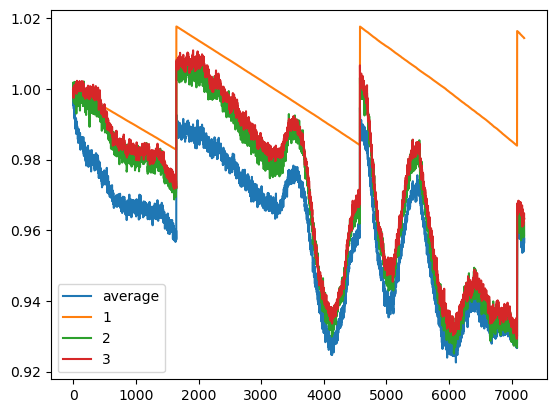

In [7]:
mm = np.mean(data,axis=(1,2))


plt.plot(mm/mm[0],label='average')
plt.plot(attrs[:,0]/attrs[0,0],label='1')
plt.plot(attrs[:,1]/attrs[0,1],label='2')
plt.plot(attrs[:,2]/attrs[0,2],label='3')
plt.legend()


# Pre-processing

28
19
37
26
24
32
36
22
33
25
26
19
21
19
28
33
32
23
35
27
30
30
24
26
28
23
24
21
23
24
27
33
28
28
28
18
26
22
24
26
24
27
27
23
24
24
28
21
26
22
19
24
23
31
19
27
22
23
28
28
21
15
24
22
19
20
29
27
16
29
25
25
24
29
24
22
19
16
25
23
21
22
23
23
26
18
21
18
26
24
24
24
21
21
30
13
20
29
28
20
27
20
20
23
23
25
28
18
25
19
13
28
26
27
17
34
21
20
30
25
23
26
18
22
26
19
14
21
31
24
22
26
28
20
22
28
24
27
26
20
20
27
20
19
41
18
19
19
27
24
26
34
22
24
31
25
32
19
26
22
21
22
30
28
19
23
27
24
21
17
21
19
28
20
23
21
21
26
27
25
31
23
27
27
24
29
24
23
31
22
29
18
23
22
22
32
18
19
25
23
22
25
16
29
20
24
21
23
15
29
27
17
24
22
16
19
29
27
15
21
25
24
14
25
33
19
25
24
20
25
20
24
19
23
23
23
24
25
17
25
17
34
18
16
21
31
22
29
32
20
21
23
33
26
23
17
17
23
25
23
28
20
29
25
30
26
25
19
27
22
22
22
24
18
19
26
20
16
32
25
25
17
27
27
22
28
24
23
21
17
27
23
33
29
23
25
20
15
19
29
22
21
24
25
23
19
22
23
25
17
18
21
21
19
22
21
13
20
21
19
25
26
22
19
26
29
25
25
22
21
30
24
28
2

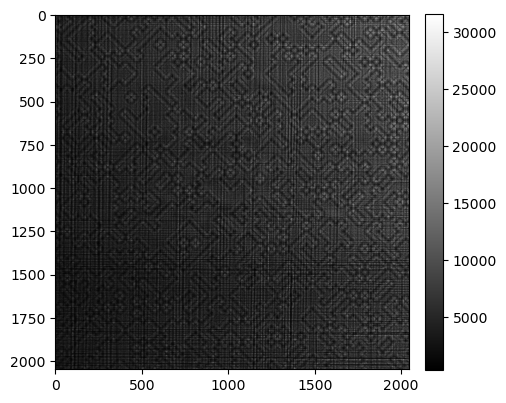

In [8]:
import cupyx.scipy.ndimage as ndimage
def remove_outliers(data, dezinger, dezinger_threshold):    
    res = data.copy()
    w = [dezinger,dezinger]
    for k in range(data.shape[0]):
        data0 = cp.array(data[k])
        fdata = ndimage.median_filter(data0, w)
        print(np.sum(np.abs(data0-fdata)>fdata*dezinger_threshold))
        res[k] = np.where(np.abs(data0-fdata)>fdata*dezinger_threshold, fdata, data0).get()
    return res

dark = np.mean(dark,axis=0)
data -= dark
ref0-=dark
ref1-=dark

data[data<0]=0
ref0[ref0<0] = 0
ref1[ref1<0] = 0
data[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = data[:,1280//3:1280//3+25//3,890//3:890//3+25//3]
ref0[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = ref0[:,1280//3:1280//3+25//3,890//3:890//3+25//3]
ref1[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = ref1[:,1280//3:1280//3+25//3,890//3:890//3+25//3]

data = remove_outliers(data, 3, 0.8)    
ref0 = remove_outliers(ref0, 3, 0.8)    
ref1 = remove_outliers(ref1, 3, 0.8)    

mshow(data[0],mshow)

In [9]:
ref0=np.mean(ref0,axis=0)
cnorm = np.mean(ref0)
data=data/cnorm/(attrs[:,1]/attrs[0,1])[:,np.newaxis,np.newaxis]
ref0/=cnorm


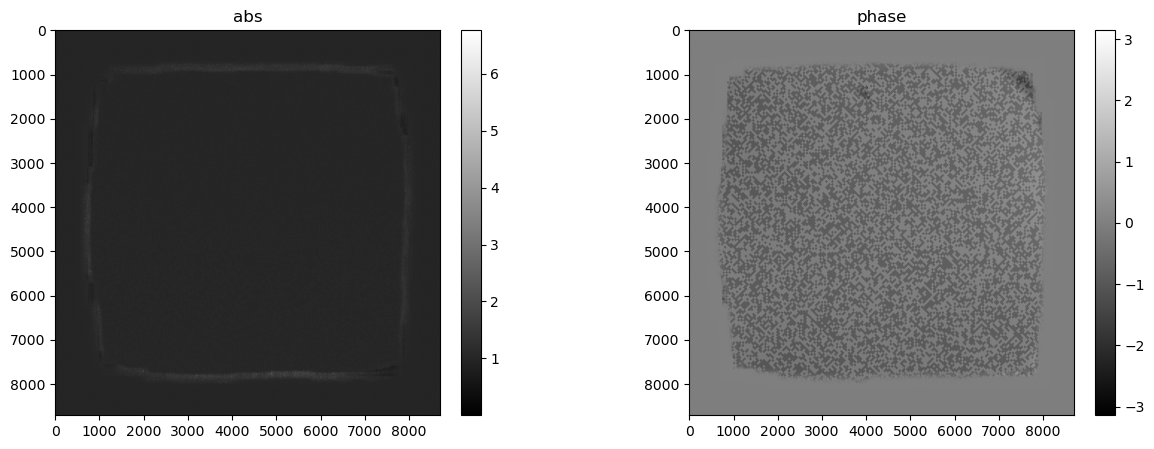

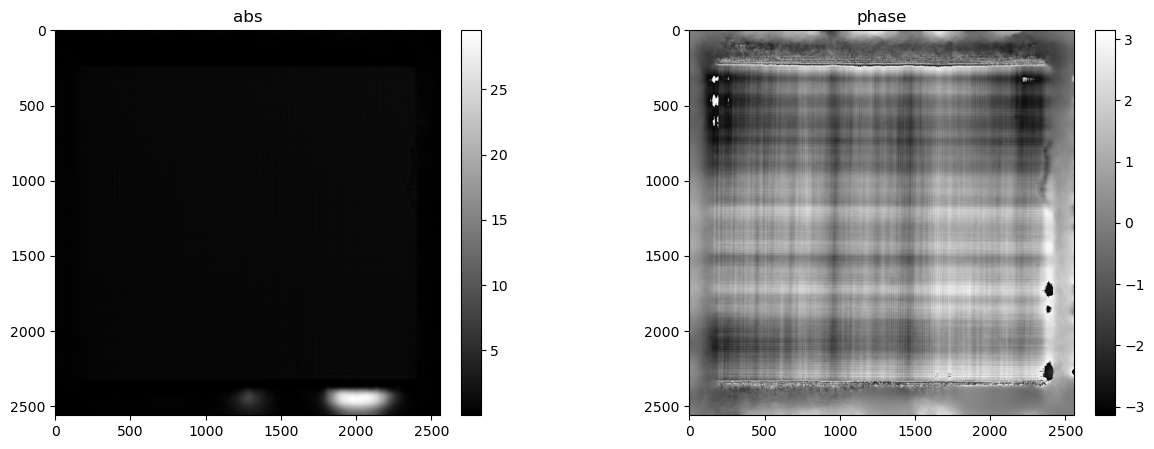

In [10]:
iter=8192
path_code = '/data/vnikitin/ESRF/ID16A/20240924_rec0224/SiemensLH/code2um_nfp18x18_01/bets_final_256_0.05_2/'
code_angle = read_tiff(f'{path_code}/rec_psi_angle/{iter:04}.tiff')
code_abs = read_tiff(f'{path_code}/rec_psi_abs/{iter:04}.tiff')
code = code_abs*np.exp(1j*code_angle)
mshow_polar(code,show)

q_angle = read_tiff(f'{path_code}/rec_prb_angle/{iter:04}.tiff')
q_abs = read_tiff(f'{path_code}/rec_prb_abs/{iter:04}.tiff')
q = q_abs*np.exp(1j*q_angle)
mshow_polar(q,show)

In [11]:
args = SimpleNamespace()

args.ngpus = 1#int(sys.args[1])
args.n = 8704
args.ncode = 8704
args.npsi = 8704
args.pad = 0
args.nq = 8704
args.ex = 0
args.npatch = 8704
args.npos = 1
args.nchunk = 1
args.ntheta=1
args.theta=np.array([0])
args.rotation_axis=0

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.distancec = distancec

# doesnt matter
args.lam = 0
args.eps = 1e-8
args.rho = [1, 0.01, 0.1]
args.crop = 0
args.path_out = ""
args.niter = 2049
args.err_step = 1
args.vis_step = 8
args.method = "BH-CG"

args.show = True

# create class
cl_rec = Rec(args)

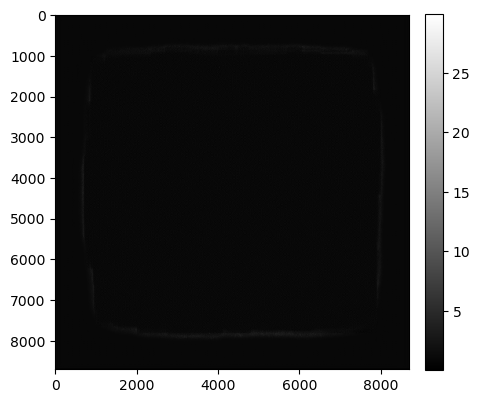

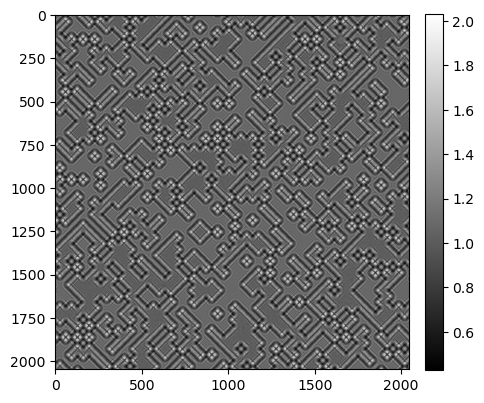

In [12]:
code =cp.array(code)
cdata = np.abs(cl_rec.D(cl_rec.Dc(code[np.newaxis]))[0])**2
mshow(cdata,show)
mshow(cdata[2000:4048,2000:4048],show)

In [17]:
args.ngpus = 4
args.n = 2048
args.pad = args.n // 8
args.npsi = args.n + 2 * args.pad
args.nq = args.n + 2 * args.pad
args.ex = 8
args.npatch = args.nq + 2 * args.ex
args.nchunk = 4
args.ntheta = len(theta)
args.theta = theta
cl_rec = Rec(args)

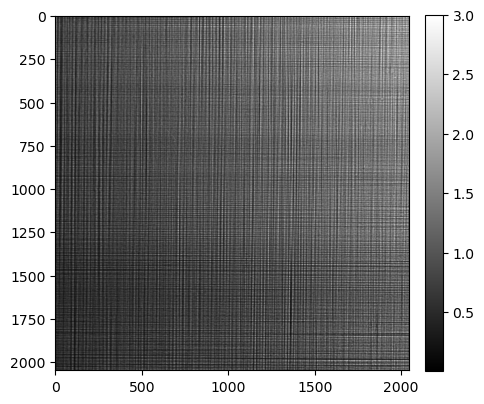

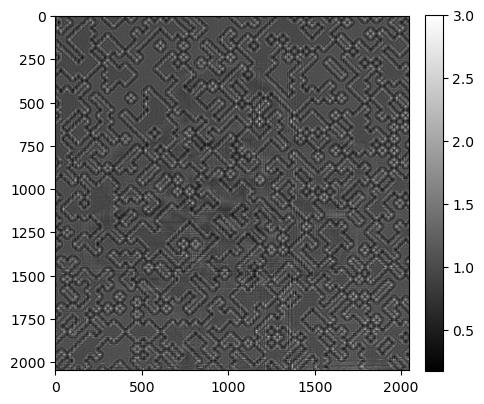

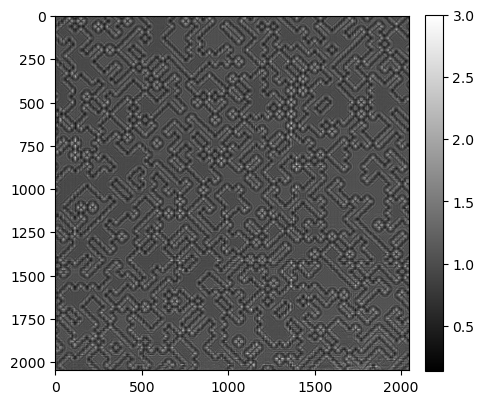

In [18]:
ref = np.abs(cl_rec.D(cl_rec.Dc(q[np.newaxis]))[0])**2
rdata = data/(ref+1e-6)
rref0 = ref0/(ref+1e-6)
mshow(ref,show,vmax=3)
mshow(rdata[0],show,vmax=3)
mshow(rref0,show,vmax=3)

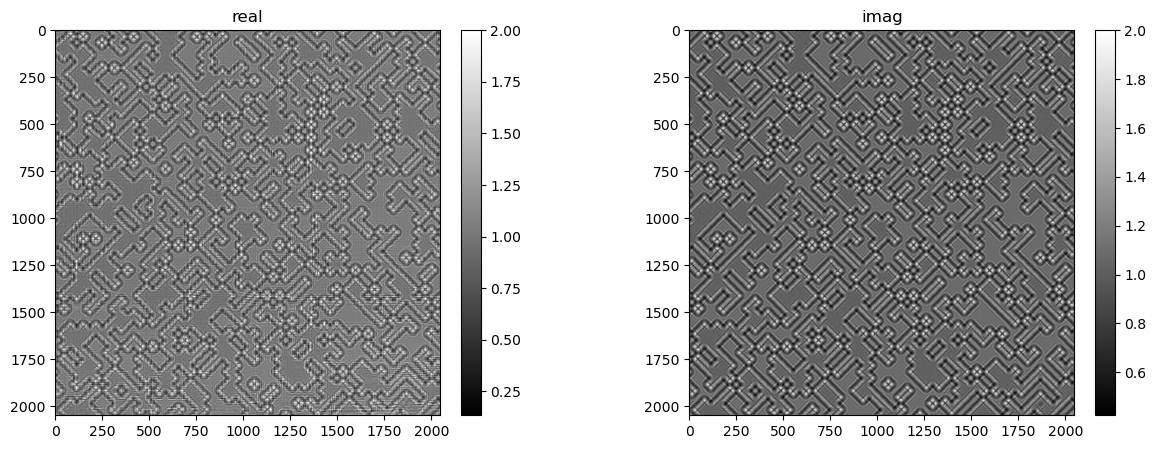

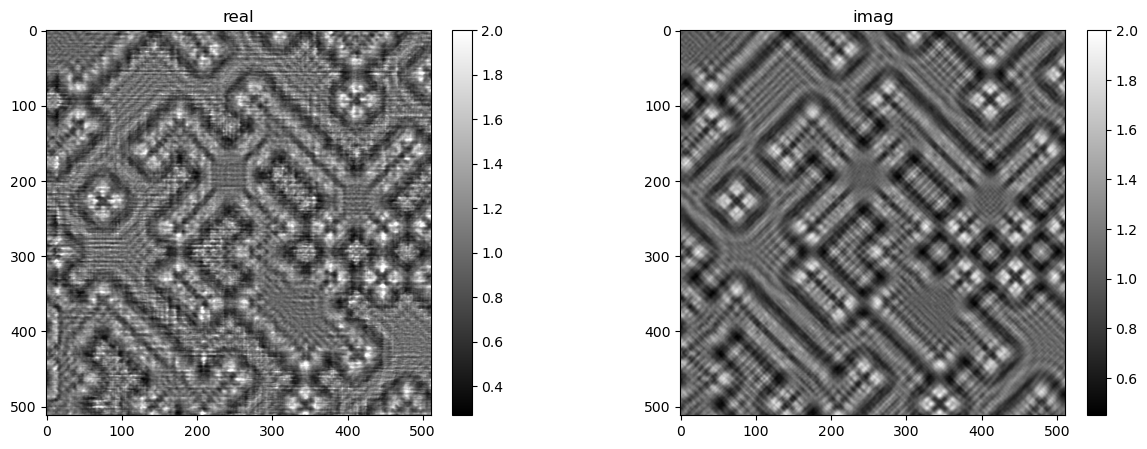

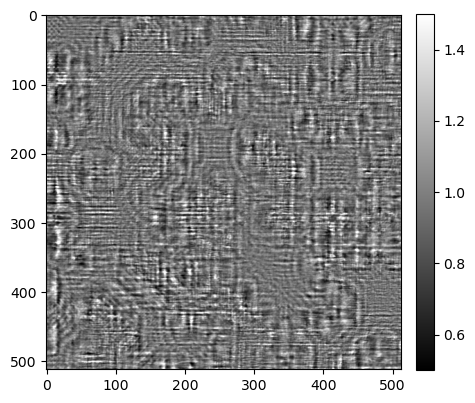

[-133.  235.]


In [19]:
def my_phase_corr(d1, d2):
    image_product = np.fft.fft2(d1) * np.fft.fft2(d2).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    ind = np.unravel_index(np.argmax(cc_image.real, axis=None), cc_image.real.shape)
    shifts = cp.zeros(2,'float32')
    shifts[0] = ind[0]
    shifts[1] = ind[1]
    shifts -= d1.shape[-1]//2
    return shifts.get()

shifts_code_ref = np.zeros([args.ntheta,2],dtype='float32')
a = cp.array(cdata)
nn = cdata.shape[-1]
rrref0=rref0.copy()
b = cp.pad(cp.array(rref0),((nn//2-args.n//2,nn//2-args.n//2),(nn//2-args.n//2,nn//2-args.n//2)),'constant',constant_values=1)
shifts_code_ref = -my_phase_corr(a,b)
aa = a[nn//2-shifts_code_ref[0]-args.n//2:nn//2-shifts_code_ref[0]+args.n//2,
        nn//2-shifts_code_ref[1]-args.n//2:nn//2-shifts_code_ref[1]+args.n//2]
bb = cp.array(rref0)
rrref0 = (bb/aa).get()
mshow_complex(bb+1j*aa,show,vmax=2)
mshow_complex(bb[512:1024,512:1024]+1j*aa[512:1024,512:1024],show,vmax=2)
mshow(rrref0[512:1024,512:1024],show,vmin=0.5,vmax=1.5)
print(shifts_code_ref)
np.save('shifts_code_ref',shifts_code_ref)

# find shift with 1 pixel accuracy

[ 78. 829.]
[1062.  242.]
[ 766. -639.]
[663. -29.]
[142. 323.]
[ 33. 764.]
[ 608. 1372.]
[1016. 1175.]
[ 93. 427.]
[ 765. -328.]
[-870. 1439.]
[362. 881.]
[-1086.  1263.]
[ 897. -652.]
[ 711. 1450.]
[849. 408.]
[-1303.   251.]
[-590. -242.]
[-598. 1140.]
[1013. 1431.]
[-1360.   891.]
[ 413. 1157.]
[855. 459.]
[-1137.  -343.]
[ 421. -644.]
[1011. 1171.]
[ 623. -203.]
[-113. -895.]
[-276. -704.]
[-334.  777.]
[852. 344.]
[-596.   42.]
[929. 696.]
[-492.  270.]
[-1252.   427.]
[-1137.  -735.]
[ 761. 1313.]
[ 101. -577.]
[-1196.  -201.]
[-764.  853.]
[-1086.   577.]
[-759. -125.]
[ 462. 1464.]
[  38. 1581.]
[-488.  583.]
[ 800. 1716.]
[-11. 520.]
[  97. -327.]
[-1144.   381.]
[1051. 1062.]
[309. 427.]
[-1085.  -104.]
[-1146.   556.]
[1013. 1875.]
[-603. 1631.]
[ 726. -511.]
[-1255.   719.]
[ 930. 1319.]
[-764. 1385.]
[-649. -765.]
[1022. -587.]
[1016.   19.]
[-1036.   266.]
[-228. 1202.]
[817. -49.]
[-333. 1544.]
[ -220. -1020.]
[-871. -533.]
[-872.  -76.]
[-1038.   903.]
[-224. -656.]
[ 

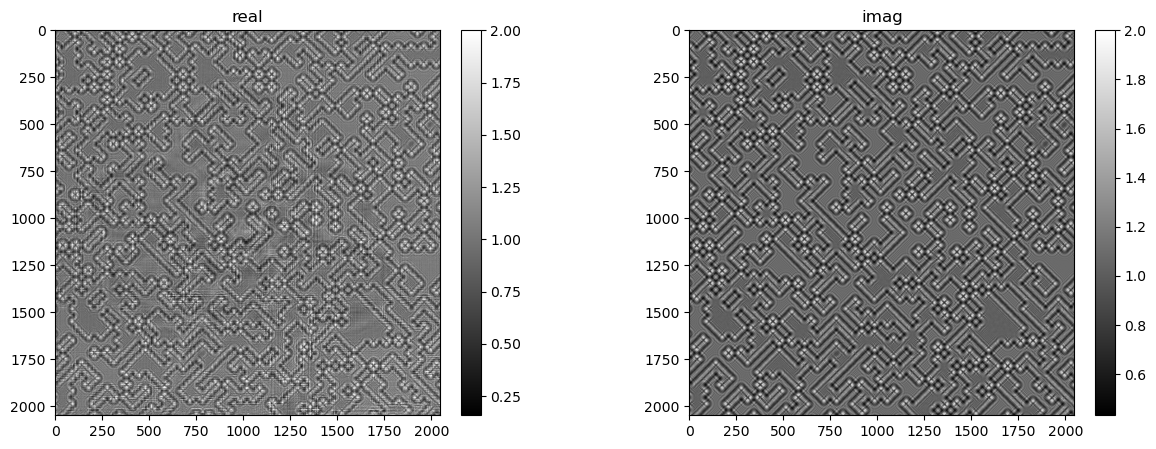

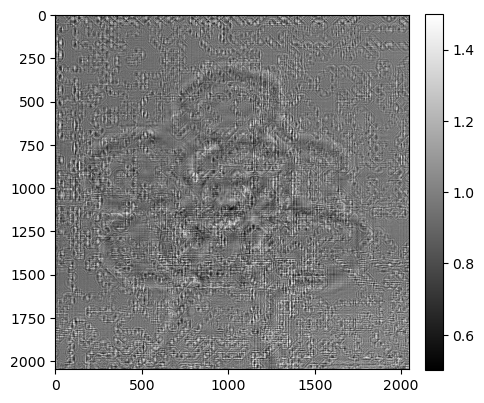

[[   78.   829.]
 [ 1062.   242.]
 [  766.  -639.]
 ...
 [ -566.   184.]
 [-1107.   201.]
 [ -401.  -851.]]


In [20]:
def my_phase_corr(d1, d2):
    image_product = np.fft.fft2(d1) * np.fft.fft2(d2).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    ind = np.unravel_index(np.argmax(cc_image.real, axis=None), cc_image.real.shape)
    shifts = cp.zeros(2,'float32')
    shifts[0] = ind[0]
    shifts[1] = ind[1]
    shifts -= d1.shape[-1]//2
    return shifts.get()

shifts_code = np.zeros([args.ntheta,2],dtype='float32')
a = cp.array(cdata)
nn = cdata.shape[-1]
rrdata=rdata.copy()
for k in range(rdata.shape[0]):        
    b = cp.pad(cp.array(rdata[k]),((nn//2-args.n//2,nn//2-args.n//2),(nn//2-args.n//2,nn//2-args.n//2)),'constant',constant_values=1)
    shift = -my_phase_corr(a,b)
    # mshow_complex(a+1j*b,show,vmax=2)
    shifts_code[k] = shift
    print(shift)
    aa = a[nn//2-shift[0]-args.n//2:nn//2-shift[0]+args.n//2,
           nn//2-shift[1]-args.n//2:nn//2-shift[1]+args.n//2]
    bb = cp.array(rdata[k])
    rrdata[k] = (bb/aa).get()
mshow_complex(bb+1j*aa,show,vmax=2)
mshow(rrdata[-1],show,vmin=0.5,vmax=1.5)
print(shifts_code)
np.save('shifts_code',shifts_code)

In [21]:
import dxchange
dxchange.write_tiff_stack(rrdata,'/data/tmp/rdata/r',overwrite=True)

astropy module not found
olefile module not found


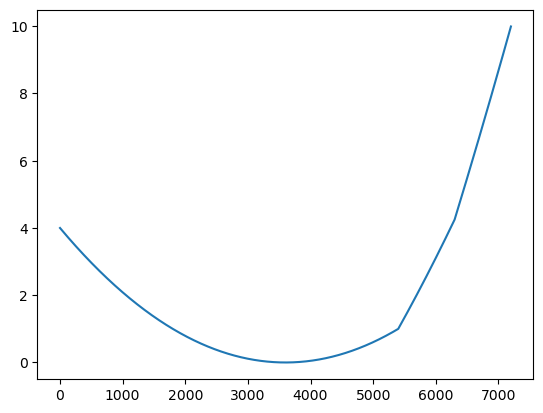

In [22]:
shifts[:5]
shifts_cor = shifts[:,::-1].copy()
v=np.arange(-ntheta//2,ntheta//2)/(ntheta//2)
cc = 4*v**2
cc[3*ntheta//4:]+=8*(v[3*ntheta//4:]-v[3*ntheta//4])
cc[7*ntheta//8:]+=8*(v[7*ntheta//8:]-v[7*ntheta//8])
shifts_cor[:,0]+=cc
plt.plot(cc)

In [23]:
def S(psi, p):
    """Apply shift for all projections."""
    res=psi.copy()
    for k in range(p.shape[0]):
        psi0 = cp.array(psi[k:k+1])
        p0 = cp.array(p[k:k+1])
        tmp = cp.pad(psi0,((0,0),(args.n//2,args.n//2),(args.n//2,args.n//2)), 'symmetric')
        [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*args.n),
                            cp.fft.fftfreq(2*args.n))
        shift = cp.exp(-2*cp.pi*1j *
                    (x*p0[:, 1, None, None]+y*p0[:, 0, None, None]))
        res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
        res[k] = res0[:, args.n//2:3*args.n//2, args.n//2:3*args.n//2].get()
    return res

srrdata = S(rrdata,-shifts_cor)
dxchange.write_tiff_stack(srrdata,'/data/tmp/s2rdata/r',overwrite=True)

In [24]:
np.save('shifts_cor',shifts_cor)

In [25]:
ri = np.round(shifts_code).astype('int32')
r = shifts_code-ri

cdata2 = np.abs(cl_rec.D(cl_rec.Dc(cl_rec.S(ri,r,code)*q)))**2

7.0005117e-09


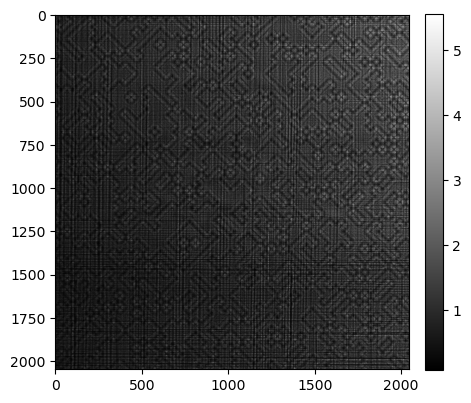

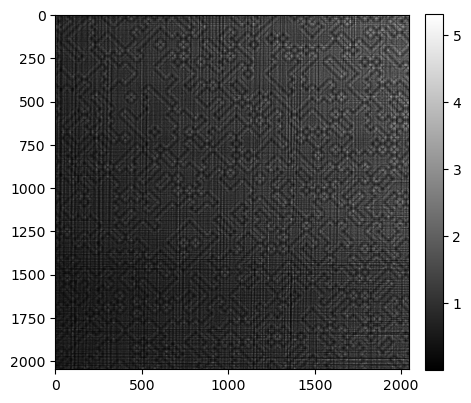

In [26]:
print(voxelsize)
mshow(data[0],show)
mshow(cdata2[0],show)

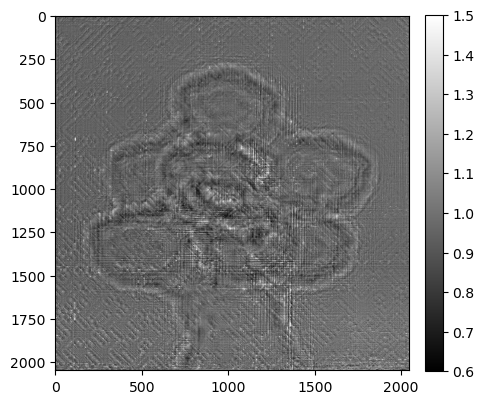

In [27]:
mshow(data[2]/cdata2[2],show,vmax=1.5,vmin=0.6)

In [28]:
cdata=cdata.get()

In [29]:
code=code.get()

In [ ]:

path_out = '/data/vnikitin/ESRF/ID16A/20240924_h5/AtomiumS2/AtomiumS2_codedht_random_007nm/'

with  h5py.File(f'{path_out}/data_corrected.h5','w') as fid:
    fid.create_dataset('/exchange/cdata2',data=cdata2)
    fid.create_dataset('/exchange/cdata',data=cdata)
    fid.create_dataset('/exchange/ref',data=ref)
    fid.create_dataset('/exchange/prb',data=q)
    fid.create_dataset('/exchange/code',data=code)
    fid.create_dataset('/exchange/shifts_cor',data=shifts_cor)
    fid.create_dataset('/exchange/shifts_code',data=shifts_code)
    dvoxelsize = fid.create_dataset('/exchange/voxelsize',shape=(1,),dtype='float32')
    dvoxelsize[0]=voxelsize
    dsx0 = fid.create_dataset('/exchange/sx0',shape=(1,),dtype='float32')
    dsx0[0] = sx0
    dz1 = fid.create_dataset('/exchange/z1',shape=(1,),dtype='float32')
    dz1[0]=z10
    ddetector_pixelsize = fid.create_dataset('/exchange/detector_pixelsize',shape=(1,),dtype='float32')
    ddetector_pixelsize[0]=detector_pixelsize
    dfocusdetectordistance = fid.create_dataset('/exchange/focusdetectordistance',shape=(1,),dtype='float32')
    dfocusdetectordistance[0]=focusToDetectorDistance
    fid.create_dataset('/exchange/data',data=data)
    fid.create_dataset('/exchange/ref0',data=ref0)
    fid.create_dataset('/exchange/ref1',data=ref1)
    fid.create_dataset('/exchange/theta',data=theta)




: 